In [4]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
import xarray as xr
import numpy as np
import regionmask
import pandas as pd
import requests
#numba hack
#https://github.com/numba/numba/issues/8615
#!pip install numpy==1.23.0

In [5]:
localdata=pd.read_csv("/home/kdm2144/mary_cmip6.csv")

In [8]:
def opendap_data(model,variable,experiment,rip):

    # Baseline directory
    base_dir   = 'http://mary.ldeo.columbia.edu:81/CMIP6/.'
    # Write directory
    
   
    df_proclist = pd.DataFrame(columns=['model','sim','ensemble','variable'])
    #ingrid_cmip6 = pd.read_csv("~/mary_cmip6.csv")



    
    #rips=np.unique(np.array(df1.member_id))

    df1=localdata[(localdata.source_id == model)\
                    & (localdata.variable_id == variable) & \
                    (localdata.experiment_id == experiment) &\
                    (localdata.member_id == rip)]
    

    #Construct openDAP link
    nfiles,nidentifiers=df1.shape
    times=np.sort(np.array(df1.time_range))
    
    time_range=times[0]

 
    i_ens=np.where(df1.time_range==time_range)[0][0]
    nc_link = base_dir+df1.activity_id.iloc[i_ens]+'/.'+df1.institution_id.iloc[i_ens]+'/.'+model+'/.'+experiment+'/.'+df1.member_id.iloc[i_ens]+'/.'+df1.table_id.iloc[i_ens]+ \
                        '/.'+variable+'/.'+df1.grid_label.iloc[i_ens]+'/.'+df1.version.iloc[i_ens]+'/.'+df1.file_basename.iloc[i_ens]+'/.'+variable+'/dods'
   
    if len(times)>1:
        nc_link=[nc_link]
        for time_range in times[1:]:
            i_ens=np.where(df1.time_range==time_range)[0][0]
            nc_link_i = base_dir+df1.activity_id.iloc[i_ens]+'/.'+df1.institution_id.iloc[i_ens]+'/.'+model+'/.'+experiment+'/.'+df1.member_id.iloc[i_ens]+'/.'+df1.table_id.iloc[i_ens]+ \
                                '/.'+variable+'/.'+df1.grid_label.iloc[i_ens]+'/.'+df1.version.iloc[i_ens]+'/.'+df1.file_basename.iloc[i_ens]+'/.'+variable+'/dods'
            nc_link+=[nc_link_i]
            
    if type(nc_link) == type([]):
        ds=xr.open_mfdataset(nc_link)
    else:
        ds=xr.open_dataset(nc_link)
    return ds




In [9]:
def write_regional_means(experiment,variable):
    subset=localdata[\
              (localdata.experiment_id == experiment) &\
    (localdata.variable_id==variable)\
             ]


    models_available = np.unique(subset.source_id)

    for model in models_available:
        rips=np.unique(subset[subset.source_id==model].member_id)
        for rip in rips:
            try:
                ds=opendap_data(model,variable,experiment,rip)

                mask_3D = regionmask.defined_regions.srex.mask_3D(getattr(ds,variable))

                weights = np.cos(np.deg2rad(getattr(ds,variable).lat))


                test_regional = ds.weighted(mask_3D * weights).mean(dim=("lat", "lon"))


                writepath="/home/kdm2144/Drawdown/DATA/"+variable+"/"+model+"/"+experiment+"/"


                os.makedirs(writepath,exist_ok=True)

                writename=".".join((variable,"Amon",model,experiment,rip,"SREX","nc"))

                test_regional.to_netcdf(path=writepath+writename)
            except:
                print(model)


In [14]:
write_hist_aer=False
if write_hist_aer:
    write_regional_means("hist-aer","tas")
    write_regional_means("hist-aer","pr")

In [ ]:
for experiment in ["hist-GHG","hist-nat"]:
    for variable in ["tas","pr"]:
        write_regional_means(experiment,variable)

In [ ]:
#getattr(test_regional,variable).isel(region=4).groupby("time.year").mean().plot()

In [12]:
#test_regional=xr.open_dataset("DATA/tas/GFDL-ESM4/hist-aer/tas.Amon.GFDL-ESM4.hist-aer.r1i1p1f1.SREX.nc")

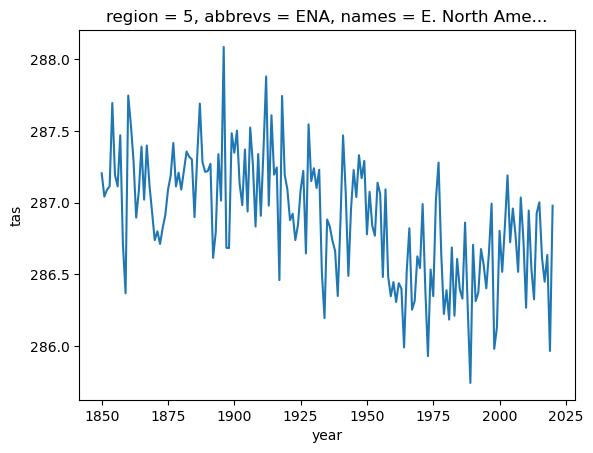

In [13]:
#variable="tas"
#getattr(test_regional,variable).isel(region=4).groupby("time.year").mean().plot()

In [ ]:
# this isn't working- eventually replace coslat weights with areacella weights

# fixedvarpath="/home/kdm2144/DROUGHT/fixedvar/"
# "areacella_fx_"+model+".nc" in os.listdir(fixedvarpath)
# area=xr.open_dataset(fixedvarpath+"areacella_fx_"+model+".nc")
# weights=area.areacella/area.areacella.sum()